After Chain Transformation PR https://github.com/pymc-devs/pymc3/pull/2968


In [1]:
%pylab inline

import numpy as np
import pymc3 as pm
import pymc3.distributions.transforms as tr
import theano.tensor as tt
import theano
import numpy.testing as npt

from pymc3.distributions.transforms import Transform

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
Order = tr.Ordered()
upper, lower = 0., 1.
Interval = tr.Interval(upper, lower)
Logodd = tr.LogOdds()
chain_tran = tr.Chain([Logodd, Order])

In [3]:
with pm.Model() as m0:
    x = pm.Uniform('x', 0., 1., shape=2,
                   transform=chain_tran,
                   testval=[0.1, 0.9])
    pm.Deterministic('jacobian', chain_tran.jacobian_det(chain_tran.forward(x)))
    
    tr0 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x_logodds_ordered__]
100%|██████████| 6000/6000 [00:08<00:00, 705.24it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '39541' (I am process '39616')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/jlao/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


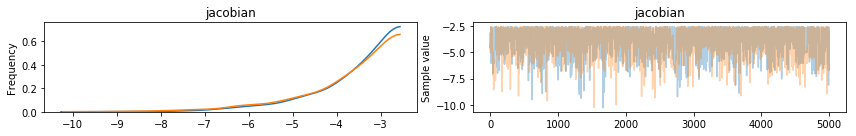

In [4]:
varnames = tr0.varnames
pm.traceplot(tr0, varnames=['jacobian']);

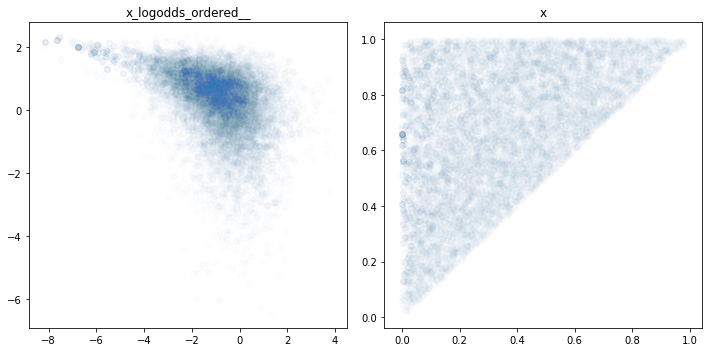

In [5]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
for ivar, varname in enumerate(varnames[:2]):
    ax[ivar].scatter(tr0[varname][:, 0], tr0[varname][:, 1], alpha=.01)
    ax[ivar].set_title(varname)
plt.tight_layout();

In [6]:
shape = (4, 2)
testval = np.random.rand(*shape)
testval = np.sort(testval/testval.sum(axis=-1, keepdims=True))
testval

array([[0.12373372, 0.87626628],
       [0.2582051 , 0.7417949 ],
       [0.2205282 , 0.7794718 ],
       [0.49246418, 0.50753582]])

In [7]:
with pm.Model() as m1:
    x = pm.Normal('x', 0., 1., shape=shape,
                   transform=Order,
                   testval=testval)
    
    tr1 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x_ordered__]
100%|██████████| 6000/6000 [00:19<00:00, 308.10it/s]


In [8]:
factors = [var.logpt for var in m1.basic_RVs] + m1.potentials
func1 = theano.function(m1.basic_RVs, factors)
func1(Order.forward_val(testval))

[array(-14.4171871)]

In [9]:
m1.logp(m1.test_point)

array(-14.4171871)

In [10]:
x0 = m1.basic_RVs[0]
x0.distribution.logp(Order.forward_val(testval)).eval()

array([-2.51376439, -2.87286009, -2.74768827, -6.28287435])

In [11]:
x = Order.forward_val(testval)
x0.distribution.logp_nojac(x).eval()

array([[-0.92659355, -1.30285983],
       [-0.95227347, -1.19406837],
       [-0.94325488, -1.22272667],
       [-1.04019902, -1.04773484]])

In [12]:
x0.distribution.transform_used.jacobian_det(x).eval()

array([-0.284311  , -0.72651825, -0.58170672, -4.1949405 ])

In [13]:
(x0.distribution.logp_nojac(x).sum(axis=-1) + x0.distribution.transform_used.jacobian_det(x)).eval()

array([-2.51376439, -2.87286009, -2.74768827, -6.28287435])

In [14]:
tt.sum(x0.distribution.logp_nojac(x).sum(axis=-1) + x0.distribution.transform_used.jacobian_det(x)).eval()

array(-14.4171871)

In [15]:
with pm.Model() as m2:
    x = pm.Uniform('x', 0., 1., shape=shape,
                   transform=chain_tran,
                   testval=testval)
    pm.Deterministic('jacobian', chain_tran.jacobian_det(chain_tran.forward(x)))
    
    tr2 = pm.sample(2500, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x_logodds_ordered__]
100%|██████████| 3500/3500 [00:10<00:00, 320.02it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


In [16]:
post_x = tr2['x']

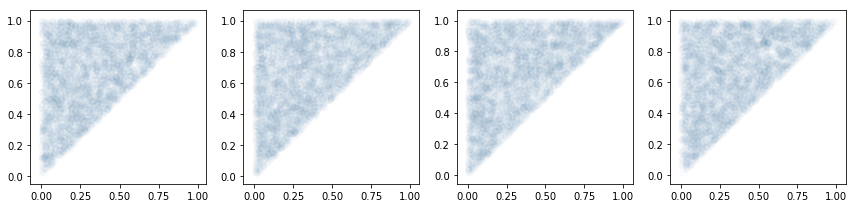

In [17]:
_, ax = plt.subplots(1, 4, figsize=(12, 3))
for ivar in range(shape[0]):
    ax[ivar].scatter(post_x[:, ivar, 0], post_x[:, ivar, 1], alpha=.01)
plt.tight_layout();

# Check elementwise logp
vectorized transformation should change the elementwise logp, by reducing the dimension:

In [18]:
print(x.ndim, m2.free_RVs[0].logp_elemwiset.ndim)

2 1


In [19]:
x_ = tt.sum(x[..., 1:], axis=-1)
x_.ndim

1

In [20]:
def check_elementwise_logp_vector_transform(model, opt=0):
    x0 = model.deterministics[0]
    x = model.free_RVs[0]
    npt.assert_equal(x.ndim-1, x.logp_elemwiset.ndim)
    
    pt = model.test_point
    array = np.random.randn(*model.bijection.map(pt).shape)
    pt2 = model.bijection.rmap(array)
    dist = x.distribution
    logp_nojac = x0.distribution.logp(dist.transform_used.backward(pt2[x.name]))
    jacob_det = dist.transform_used.jacobian_det(pt2[x.name])
    npt.assert_equal(x.logp_elemwiset.ndim, jacob_det.ndim)
    
    if opt==0:
        elementwiselogp = logp_nojac.sum(axis=-1) + jacob_det
    else:
        elementwiselogp = logp_nojac + jacob_det
                      
    npt.assert_array_almost_equal(x.logp_elemwise(pt2),
                                  elementwiselogp.eval())
    
check_elementwise_logp_vector_transform(m0)
check_elementwise_logp_vector_transform(m1)
check_elementwise_logp_vector_transform(m2)

In [21]:
with pm.Model() as m:
    x = pm.Normal('x', shape=(4, 2))
print(x.ndim, m.free_RVs[0].logp_elemwiset.ndim)

2 2


In [22]:
x_ = tt.sum(x[..., 1:], axis=-1)
x_.ndim

1

In [23]:
with pm.Model() as m:
    x = pm.Normal('x', shape=2)
print(x.ndim, m.free_RVs[0].logp_elemwiset.ndim)

1 1


In [24]:
x_ = tt.sum(x[..., 1:], axis=-1)
x_.ndim

0

# Check other transformation (stickbreaking etc)

In [25]:
with pm.Model() as m:
    x = pm.Dirichlet('x', a=np.ones(3))

check_elementwise_logp_vector_transform(m, opt=1)

In [26]:
with pm.Model() as m:
    x = pm.Dirichlet('x', a=np.ones((2, 3)), shape=(2, 3))

check_elementwise_logp_vector_transform(m, opt=1)

In [27]:
with pm.Model() as m:
    x = pm.Uniform('x', shape=3, testval=np.ones(3),
                     transform=tr.stick_breaking)

check_elementwise_logp_vector_transform(m, opt=0)

In [28]:
with pm.Model() as m:
    x = pm.Uniform('x', shape=(4, 3), testval=np.ones((4, 3)),
                     transform=tr.stick_breaking)

check_elementwise_logp_vector_transform(m, opt=0)

In [29]:
with pm.Model() as m:
    x = pm.Normal('x', shape=3, testval=np.ones(3)/3,
                     transform=tr.sum_to_1)

check_elementwise_logp_vector_transform(m, opt=0)

In [30]:
with pm.Model() as m:
    x = pm.Normal('x', shape=(4, 3), testval=np.ones((4, 3))/3,
                     transform=tr.sum_to_1)

check_elementwise_logp_vector_transform(m, opt=0)

In [31]:
with pm.Model() as m:
    x = pm.MvNormal('x',
                    mu=np.zeros(3),
                    cov=np.diag(np.ones(3)),
                    shape=(4, 3), 
                    testval=np.sort(np.random.randn(4, 3)),
                    transform=tr.ordered)

check_elementwise_logp_vector_transform(m, opt=1)

# Elementwise transform logp check

In [32]:
def check_elementwise_logp_transform(model):
    x0 = model.deterministics[0]
    x = model.free_RVs[0]
    npt.assert_equal(x.ndim, x.logp_elemwiset.ndim)
    
    pt = model.test_point
    array = np.random.randn(*model.bijection.map(pt).shape)
    pt2 = model.bijection.rmap(array)
    dist = x.distribution
    logp_nojac = x0.distribution.logp(dist.transform_used.backward(pt2[x.name]))
    jacob_det = dist.transform_used.jacobian_det(pt2[x.name])
    npt.assert_equal(x.logp_elemwiset.ndim, jacob_det.ndim)
    
    elementwiselogp = logp_nojac + jacob_det
                      
    npt.assert_array_almost_equal(x.logp_elemwise(pt2),
                                  elementwiselogp.eval())

In [33]:
with pm.Model() as m:
    x = pm.VonMises('x', -2.5, 2., shape=(5, 3))

check_elementwise_logp_transform(m)

In [34]:
with pm.Model() as m:
    x = pm.VonMises('x', -2.5, 2.)
    trace = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x_circular__]
100%|██████████| 6000/6000 [00:05<00:00, 1063.94it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6880368497616789, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9976100510029626, but should be close to 0.8. Try to increase the number of tuning steps.


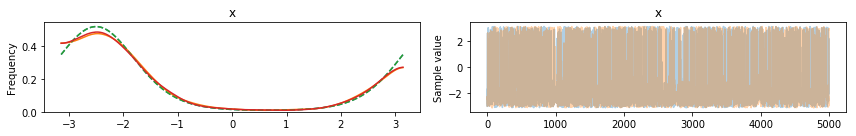

In [35]:
pm.traceplot(trace, priors=[x.distribution]);

# Multiple chain transformation

In [36]:
Order = tr.Ordered()
Logodd = tr.LogOdds()
stickbreak = tr.StickBreaking()
sumto1 = tr.SumTo1()

chain_tran = tr.Chain([sumto1, Logodd])

In [37]:
x = np.random.randn(4, 2)
y = chain_tran.backward(x).eval()
y

array([[ 0.37068537,  0.23440773,  0.3949069 ],
       [ 0.81293576,  0.63187005, -0.44480581],
       [ 0.44363358,  0.41734766,  0.13901875],
       [ 0.78220152,  0.23234958, -0.0145511 ]])

In [38]:
chain_tran.forward(y).eval()

array([[-0.52927771, -1.18358768],
       [ 1.4692    ,  0.54024774],
       [-0.22642815, -0.33367107],
       [ 1.27854216, -1.19509138]])

In [39]:
x

array([[-0.52927771, -1.18358768],
       [ 1.4692    ,  0.54024774],
       [-0.22642815, -0.33367107],
       [ 1.27854216, -1.19509138]])

In [40]:
with pm.Model() as m:
    x = pm.Uniform('x', 0., 1., shape=shape,
                   transform=chain_tran,
                   testval=testval)

check_elementwise_logp_vector_transform(m, opt=0)

In [41]:
x_tr = m.free_RVs[0]
jac = x_tr.distribution.transform_used.jacobian_det(testval)
print(x.ndim, x_tr.logp_elemwiset.ndim, jac.ndim)

2 1 1


In [42]:
with m:
    tr1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x_sumto1_logodds__]
100%|██████████| 1000/1000 [00:01<00:00, 860.94it/s]


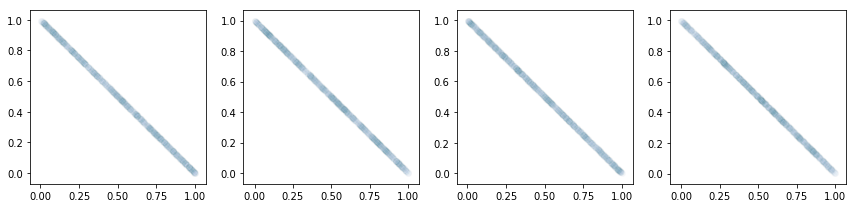

In [43]:
post_x = tr1['x']
_, ax = plt.subplots(1, 4, figsize=(12, 3))
for ivar in range(shape[0]):
    ax[ivar].scatter(post_x[:, ivar, 0], post_x[:, ivar, 1], alpha=.01)
plt.tight_layout();

In [44]:
x_tr.distribution.logp_nojac(m.test_point[x_tr.name]).eval()

array([[-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.]])

In [45]:
x_tr.distribution.transform_used.jacobian_det(m.test_point[x_tr.name]).eval()

array([-2.22170873, -1.65268354, -1.76086846, -1.38652154])

In [46]:
trlist = x_tr.distribution.transform_used.transform_list

In [47]:
trlist[-1].jacobian_det(theano.shared(m.test_point[x_tr.name])).eval()

array([[-2.22170873],
       [-1.65268354],
       [-1.76086846],
       [-1.38652154]])

In [48]:
(trlist[0]
 .jacobian_det(
    trlist[1].backward(
        theano.shared(m.test_point[x_tr.name])
    )
 )
).eval()

array([0., 0., 0., 0.])

In [49]:
chain_tran = tr.Chain([sumto1, Logodd, Order])

In [50]:
x = np.random.randn(4, 2)
y = chain_tran.backward(x).eval()
y

array([[ 0.5121575 ,  0.91014896, -0.42230646],
       [ 0.68079185,  0.99999345, -0.6807853 ],
       [ 0.0524954 ,  0.40158088,  0.54592371],
       [ 0.37958043,  0.41168629,  0.20873328]])

In [51]:
chain_tran.forward(y).eval()

array([[ 0.04863958,  0.818376  ],
       [ 0.75741321,  2.41397779],
       [-2.8931062 ,  0.91397758],
       [-0.49132945, -2.00745024]])

In [52]:
x

array([[ 0.04863958,  0.818376  ],
       [ 0.75741321,  2.41397779],
       [-2.8931062 ,  0.91397758],
       [-0.49132945, -2.00745024]])

In [53]:
with pm.Model() as m:
    x = pm.Uniform('x', 0., 1., shape=shape,
                   transform=chain_tran,
                   testval=testval)

check_elementwise_logp_vector_transform(m, opt=0)

In [54]:
with m:
    tr1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR (theano.gof.opt): Optimization failure due to: local_dimshuffle_subtensor
ERROR (theano.gof.opt): node: InplaceDimShuffle{0}(Subtensor{::, ::int64}.0)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/theano/gof/opt.py", line 2059, in process_node
    remove=remove)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/theano/gof/toolbox.py", line 569, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/theano/gof/toolbox.py", line 518, in replace_all_validate
    fgraph.replace(r, new_r, reason=reason, verbose=False)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/theano/gof/fg.py", li

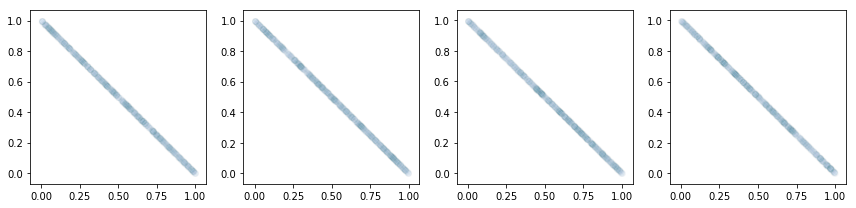

In [55]:
post_x = tr1['x']
_, ax = plt.subplots(1, 4, figsize=(12, 3))
for ivar in range(shape[0]):
    ax[ivar].scatter(post_x[:, ivar, 0], post_x[:, ivar, 1], alpha=.01)
plt.tight_layout();

In [57]:
chain_tran = tr.Chain([sumto1, Interval])
with pm.Model() as m:
    x = pm.Uniform('x', 
                     shape=shape, 
                     transform=chain_tran, 
                     testval=testval)
    x_ = pm.Deterministic('x_', tt.sort(x))

check_elementwise_logp_vector_transform(m, opt=0)

with m:
    tr1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x_sumto1_interval__]
100%|██████████| 1000/1000 [00:01<00:00, 767.88it/s]


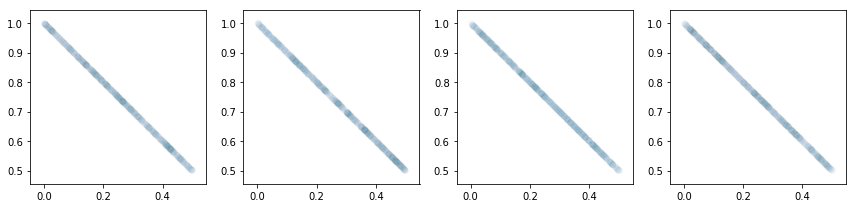

In [58]:
post_x = tr1['x_']
_, ax = plt.subplots(1, 4, figsize=(12, 3))
for ivar in range(shape[0]):
    ax[ivar].scatter(post_x[:, ivar, 0], post_x[:, ivar, 1], alpha=.01)
plt.tight_layout();